In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
! git clone 'https://github.com/UCSD-AI4H/COVID-CT.git'

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 13.09 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [ ]:
import os

In [ ]:
os.mkdir('/content/COVID-CT/Images-processed/ci')
os.mkdir('/content/COVID-CT/Images-processed/nci')

In [ ]:
!unzip '/content/COVID-CT/Images-processed/CT_COVID.zip' -d '/content/COVID-CT/Images-processed/ci'

Archive:  /content/COVID-CT/Images-processed/CT_COVID.zip
   creating: /content/COVID-CT/Images-processed/ci/CT_COVID/
  inflating: /content/COVID-CT/Images-processed/ci/CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: /content/COVID-CT/Images-processed/ci/__MACOSX/
   creating: /content/COVID-CT/Images-processed/ci/__MACOSX/CT_COVID/
  inflating: /content/COVID-CT/Images-processed/ci/__MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: /content/COVID-CT/Images-processed/ci/CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: /content/COVID-CT/Images-processed/ci/__MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: /content/COVID-CT/Images-processed/ci/CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: /content/COVID-CT/Images-processed/ci/__MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inflating: /content/COVID-CT/

In [ ]:
!unzip '/content/COVID-CT/Images-processed/CT_NonCOVID.zip' -d '/content/COVID-CT/Images-processed/nci'

Archive:  /content/COVID-CT/Images-processed/CT_NonCOVID.zip
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/0.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/1%0.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/1%1.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/1%2.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/10%0.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/10%1.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/10%2.jpg  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/102.png  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/1029.png  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/103.png  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/1030.png  
  inflating: /content/COVID-CT/Images-processed/nci/CT_NonCOVID/104.png  
  inflating: /content/COVID-CT/Images-processed/

In [ ]:
from scipy.misc import face
from scipy.signal.signaltools import wiener
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.metrics import AUC,Precision,Recall
from sklearn.model_selection import KFold
import math
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import random
import shutil
import glob

In [ ]:
trainp=pd.read_csv('/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt')
trainp.columns=['A']
testp=pd.read_csv('/content/COVID-CT/Data-split/COVID/testCT_COVID.txt')
testp.columns=['A']
valp=pd.read_csv('/content/COVID-CT/Data-split/COVID/valCT_COVID.txt')
valp.columns=['A']

trainn=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt')
trainn.columns=['A']
testn=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt')
testn.columns=['A']
valn=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt')
valn.columns=['A']

In [ ]:
covp=list(os.listdir('/content/COVID-CT/Images-processed/ci/CT_COVID'))
covn=list(os.listdir('/content/COVID-CT/Images-processed/nci/CT_NonCOVID'))

In [ ]:
print(len(covp))
print(len(covn))

349
397


In [ ]:
trainp.shape

(190, 1)

In [ ]:
#for cov positive
#train images
#flip horizontal
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,96):
  img_path=source+'/'+str(trainp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(trainp.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainp=trainp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#train images
#flip vertical
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(96,191):
  img_path=source+'/'+str(trainp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(trainp.A[i])+'_vertical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainp=trainp.append(modimgdf, ignore_index = True)

In [ ]:
trainp.shape

(381, 1)

In [ ]:
#for cov positive
#train images
#rotate 10 degree
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,190):
  img_path=source+'/'+str(trainp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(trainp.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainp=trainp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#train images
#horizontal shift
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,190):
  img_path=source+'/'+str(trainp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(trainp.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainp=trainp.append(modimgdf, ignore_index = True)

In [ ]:
valp.shape

(59, 1)

In [ ]:
#for cov positive
#val images
#flip horizontal
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,31):
  img_path=source+'/'+str(valp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(valp.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valp=valp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#val images
#flip vertical
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(31,60):
  img_path=source+'/'+str(valp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(valp.A[i])+'_vertical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valp=valp.append(modimgdf, ignore_index = True)

In [ ]:
valp.shape

(119, 1)

In [ ]:
#for cov positive
#val images
#rotated 10 degree
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,61):
  img_path=source+'/'+str(valp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(valp.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valp=valp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#val images
#horizontal shift
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(61,120):
  img_path=source+'/'+str(valp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(valp.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valp=valp.append(modimgdf, ignore_index = True)

In [ ]:
trainn.shape

(233, 1)

In [ ]:
#for cov negative
#train images
#flip horizontal
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,116):
  img_path=source+'/'+str(trainn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(trainn.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainn=trainn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#train images
#flip vertical
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(117,233):
  img_path=source+'/'+str(trainn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(trainn.A[i])+'_vdrtical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainn=trainn.append(modimgdf, ignore_index = True)

In [ ]:
trainn.shape

(465, 1)

In [ ]:
#for cov negative
#train images
#rotated 10 degree
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,232):
  img_path=source+'/'+str(trainn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(trainn.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainn=trainn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#train images
#horizontal shift
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(233,466):
  img_path=source+'/'+str(trainn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(trainn.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
trainn=trainn.append(modimgdf, ignore_index = True)

In [ ]:
valn.shape

(57, 1)

In [ ]:
#for cov negative
#val images
#flip horizontal
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,29):
  img_path=source+'/'+str(valn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(valn.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valn=valn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#val images
#flip vertical
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(29,58):
  img_path=source+'/'+str(valn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(valn.A[i])+'_vertical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valn=valn.append(modimgdf, ignore_index = True)

In [ ]:
valn.shape

(115, 1)

In [ ]:
#for cov negative
#val images
#rotated by 10 degree
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,58):
  img_path=source+'/'+str(valn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(valn.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valn=valn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#val images
#horizontal shift
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(58,116):
  img_path=source+'/'+str(valn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(valn.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
valn=valn.append(modimgdf, ignore_index = True)

In [ ]:
testp.shape

(97, 1)

In [ ]:
#for cov positive
#test images
#flip horizontal
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,48):
  img_path=source+'/'+str(testp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(testp.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testp=testp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#test images
#flip vertical
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(48,98):
  img_path=source+'/'+str(testp.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(testp.A[i])+'_vertical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testp=testp.append(modimgdf, ignore_index = True)

In [ ]:
testp.shape

(195, 1)

In [ ]:
#for cov positive
#test images
#rotate 10 degree
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(0,98):
  img_path=source+'/'+str(testp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(testp.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testp=testp.append(modimgdf, ignore_index = True)

In [ ]:
#for cov positive
#test images
#horizontal shift
source='/content/COVID-CT/Images-processed/ci/CT_COVID'
for i in range(98,196):
  img_path=source+'/'+str(testp.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(testp.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testp=testp.append(modimgdf, ignore_index = True)

In [ ]:
testn.shape

(104, 1)

In [ ]:
#for cov negative
#test images
#flip horizontal
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,53):
  img_path=source+'/'+str(testn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,1)
  save_name=str(testn.A[i])+'_horrotated'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testn=testn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#test images
#flip vertical
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(53,105):
  img_path=source+'/'+str(testn.A[i])
  img=cv2.imread(img_path)
  flipHorizontal = cv2.flip(img,0)
  save_name=str(testn.A[i])+'_vdrtical'+'.jpeg'
  cv2.imwrite(save_name,flipHorizontal)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testn=testn.append(modimgdf, ignore_index = True)

In [ ]:
testn.shape

(209, 1)

In [ ]:
#for cov negative
#test images
#rotated 10 degree
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(0,104):
  img_path=source+'/'+str(testn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  center = (int(width/2), int(height/2))
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=10, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  save_name=str(testn.A[i])+'_rotated'+'.jpeg'
  cv2.imwrite(save_name,rotated_image)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testn=testn.append(modimgdf, ignore_index = True)

In [ ]:
#for cov negative
#train images
#horizontal shift
source='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
for i in range(105,210):
  img_path=source+'/'+str(testn.A[i])
  image=cv2.imread(img_path)
  height, width = image.shape[:2]
  quarter_height, quarter_width = height / 8, width / 4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  img_translation = cv2.warpAffine(image, T, (width, height))

  save_name=str(testn.A[i])+'_horshift'+'.jpeg'
  cv2.imwrite(save_name,img_translation)
 
 
modimg=[]
source='/content'
dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
import shutil
total_list_img=os.listdir('/content')
img_list=[]
for i in total_list_img:
  if i.endswith('.jpeg'):
    img_list.append(i)
for i in img_list:
  modimg.append(i)
  shutil.move(source+'/'+str(i),dest)

In [ ]:
modimgdict={
    'A':modimg
}
modimgdf=pd.DataFrame(modimgdict)
testn=testn.append(modimgdf, ignore_index = True)

In [ ]:
os.remove('/content/COVID-CT/Data-split/COVID/testCT_COVID.txt')
os.remove('/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt')
os.remove('/content/COVID-CT/Data-split/COVID/valCT_COVID.txt')

os.remove('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt')
os.remove('/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt')
os.remove('/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt')

In [ ]:
numpy_array = trainp.to_numpy()
np.savetxt("trainCT_COVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/trainCT_COVID.txt','/content/COVID-CT/Data-split/COVID')

'/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt'

In [ ]:
numpy_array = testp.to_numpy()
np.savetxt("testCT_COVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/testCT_COVID.txt','/content/COVID-CT/Data-split/COVID')

numpy_array = valp.to_numpy()
np.savetxt("valCT_COVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/valCT_COVID.txt','/content/COVID-CT/Data-split/COVID')

numpy_array = trainn.to_numpy()
np.savetxt("trainCT_NonCOVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/trainCT_NonCOVID.txt','/content/COVID-CT/Data-split/NonCOVID')

numpy_array = testn.to_numpy()
np.savetxt("testCT_NonCOVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/testCT_NonCOVID.txt','/content/COVID-CT/Data-split/NonCOVID')

numpy_array = valn.to_numpy()
np.savetxt("valCT_NonCOVID.txt", numpy_array, fmt = "%s")
shutil.move('/content/valCT_NonCOVID.txt','/content/COVID-CT/Data-split/NonCOVID')

'/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt'

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
path='/content/COVID-CT/Images-processed/ci/CT_COVID'
img_list=os.listdir(path)
len(img_list)

1790

In [ ]:
c=0
for i in img_list:
  img_path=path+'/'+str(i)
  image=cv2.imread(img_path)
  normalizedImg = np.zeros((800, 800))
  dst = cv2.normalize(image,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
  im_color = cv2.applyColorMap(dst, cv2.COLORMAP_BONE)
  cv2.imwrite(str(i),im_color)
  c=c+1
  print(c) 
#removing files in images folder
fileinimages=os.listdir(path)
for i in fileinimages:
  os.remove(path+'/'+str(i))
filelist=os.listdir('/content/')
filelistjpg=[]
for fichier in filelist:
    if (fichier.endswith(".JPG")) or fichier.endswith('.png') or fichier.endswith('.jpeg') or fichier.endswith('.jpg'):
        filelistjpg.append(fichier)
print(filelistjpg)
print(len(filelistjpg))
for i in filelistjpg:
  source='/content/'+str(i)
  dest='/content/COVID-CT/Images-processed/ci/CT_COVID'
  shutil.move(source,dest)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
path='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
img_list=os.listdir(path)
len(img_list)

1186

In [ ]:
#applying clahe
c=0
for i in img_list:
  img_path=path+'/'+str(i)
  image=cv2.imread(img_path)
  normalizedImg = np.zeros((800, 800))
  dst = cv2.normalize(image,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
  im_color = cv2.applyColorMap(dst, cv2.COLORMAP_BONE)
  cv2.imwrite(str(i),im_color)
  c=c+1
  print(c) 
#removing files in images folder
fileinimages=os.listdir(path)
for i in fileinimages:
  os.remove(path+'/'+str(i))
filelist=os.listdir('/content/')
filelistjpg=[]
for fichier in filelist:
    if (fichier.endswith(".JPG")) or fichier.endswith('.png') or fichier.endswith('.jpeg') or fichier.endswith('.jpg'):
        filelistjpg.append(fichier)
print(filelistjpg)
print(len(filelistjpg))
for i in filelistjpg:
  source='/content/'+str(i)
  dest='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
  shutil.move(source,dest)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
path='/content/COVID-CT/Images-processed/ci/CT_COVID'
c_list=os.listdir(path)
print(len(c_list))
c1=np.sort(c_list)
f=[]

1790


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,\
    Dropout, Dense, Input, concatenate, ZeroPadding2D,  \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, add, Activation, Flatten,GlobalMaxPool2D

In [ ]:
model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = Model(inputs=model.input, outputs=model.layers[-160].output) #150 is a good fit
x=GlobalAveragePooling2D()(model.output)
model = Model(inputs=model.input, outputs=x)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
ichange=768

In [ ]:
'''model = tf.keras.applications.ResNet50V2(weights=None,include_top=False,input_shape=(224,224,3))
x=GlobalAveragePooling2D()(model.output)
model = Model(inputs=model.input, outputs=x)
model.summary()'''

'model = tf.keras.applications.ResNet50V2(weights=None,include_top=False,input_shape=(224,224,3))\nx=GlobalAveragePooling2D()(model.output)\nmodel = Model(inputs=model.input, outputs=x)\nmodel.summary()'

In [ ]:
# import pydot
# from keras.utils.vis_utils import plot_model
# plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.preprocessing import image 
for i in c1:
  img_path=path+'/'+str(i)
  img = image.load_img(img_path, target_size=(224, 224))  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.resnet_v2.preprocess_input(x)
  features = model.predict(x)
  features =features.reshape(ichange,)
  abs=[features,str(i),str(1)]
  f.append(abs)

In [ ]:
df=pd.DataFrame(f)

In [ ]:
df.head(2)

,0,1,2
0,"[0.15445012, 0.14575681, 0.22752973, 0.4538171...",0.jpg_horrotated.jpeg_horshift.jpeg,1
1,"[0.1649938, 0.2959214, 0.2580663, 0.48762333, ...",1%0.jpg_horrotated.jpeg_horshift.jpeg,1


In [ ]:
path='/content/COVID-CT/Images-processed/nci/CT_NonCOVID'
c2=os.listdir(path) 
print(len(c2))

1186


In [ ]:
c2=np.sort(c2)
f1=[]

In [ ]:
from keras.preprocessing import image 
for i in c2:
  img_path=path+'/'+str(i)
  img = image.load_img(img_path, target_size=(224, 224))  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.resnet_v2.preprocess_input(x)
  features = model.predict(x)
  features =features.reshape(ichange,)
  abs=[features,str(i),str(0)]
  f1.append(abs)

In [ ]:
fd=[f,f1]

In [ ]:
df=pd.read_csv('/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt')
df.columns=['A']
df1=pd.read_csv('/content/COVID-CT/Data-split/COVID/testCT_COVID.txt')
df1.columns=['A']
df2=pd.read_csv('/content/COVID-CT/Data-split/COVID/valCT_COVID.txt')
df2.columns=['A']

In [ ]:
d=df['A'].to_list()
d1=df1['A'].to_list()
d2=df2['A'].to_list()

In [ ]:
ctrl=[]
ctel=[]
cval=[]

In [ ]:
for i in fd:
  for j in i:
    for k in d:
      if j[1]==k:
         ctrl.append(np.asarray(j))
for i in fd:
  for j in i:
    for k in d1:
      if j[1]==k:
         ctel.append(np.asarray(j))
for i in fd:
  for j in i:
    for k in d2:
      if j[1]==k:
         cval.append(np.asarray(j))                         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
df=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt')
df.columns=['A']
df1=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt')
df1.columns=['A']
df2=pd.read_csv('/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt')
df2.columns=['A']

In [ ]:
d=df['A'].to_list()
d1=df1['A'].to_list()
d2=df2['A'].to_list()

In [ ]:
nctrl=[]
nctel=[]
ncval=[]

In [ ]:
for i in fd:
  for j in i:
    for k in d:
      if j[1]==k:
         nctrl.append(np.asarray(j))
for i in fd:
  for j in i:
    for k in d1:
      if j[1]==k:
         nctel.append(np.asarray(j))
for i in fd:
  for j in i:
    for k in d2:
      if j[1]==k:
         ncval.append(np.asarray(j))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
cdf=pd.DataFrame(ctrl)
cdf1=pd.DataFrame(nctrl)
cdf2=pd.DataFrame(ncval)
cdf3=pd.DataFrame(cval)
df=cdf.append(cdf1)
df=df.append(cdf2)
df=df.append(cdf3)

In [ ]:
listf=list(df[0])

In [ ]:
len(listf)

2157

In [ ]:
lis=[]
for i in range(ichange):
  for j in range(2157):
    lis.append(listf[j][i])
  df[str(i)]=lis
  lis=[]

In [ ]:
df.rename(columns=
           {1:'image_name',
            0:'nullo'
            },inplace=True)

In [ ]:
df.head(2)

,nullo,image_name,2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,"[0.27380016, 0.20552638, 0.23234017, 0.2169183...",2020.01.24.919183-p27-133.png_horrotated.jpeg,1,0.273800,0.205526,0.232340,0.216918,0.505242,0.671197,0.283175,0.346610,0.619639,0.725343,0.191489,0.382834,0.096507,0.135309,0.098076,0.125198,0.338269,0.123672,0.455927,0.266715,0.364140,0.145616,0.165001,0.326977,0.617098,0.107947,0.274098,0.346568,0.437027,0.537585,0.290232,0.694717,0.081027,0.235531,0.236749,0.742811,0.302273,...,0.01286,0.011977,0.000884,0.054096,0.065007,0.057213,0.015485,0.062528,0.037786,0.114139,0.116784,0.092046,0.205380,0.049488,0.530853,0.566930,0.0,0.121314,0.207660,0.172637,0.036574,0.157670,0.065771,0.319557,0.112634,0.024805,0.434925,0.015532,0.11565,0.014111,0.022333,0.046761,0.324629,0.023576,0.430625,0.012814,0.334948,0.038747,0.030224,0.000000
1,"[0.20799494, 0.19026917, 0.15881571, 0.3651901...",2020.01.24.919183-p27-133.png_horshift.jpeg,1,0.207995,0.190269,0.158816,0.365190,0.380820,0.827479,0.192850,0.192781,0.311548,0.447050,0.285024,0.235273,0.105775,0.137993,0.298282,0.180933,0.302001,0.066968,0.472174,0.284080,0.374545,0.064360,0.230979,0.416127,0.497724,0.155622,0.179602,0.279797,0.369646,0.634562,0.234996,0.392386,0.124087,0.288968,0.184025,0.483124,0.180528,...,0.08341,0.091040,0.000000,0.068216,0.022356,0.161545,0.061893,0.113625,0.046607,0.132251,0.118967,0.164798,0.195252,0.381504,0.250666,0.332751,0.0,0.069299,0.271147,0.058192,0.151016,0.014541,0.085328,0.371290,0.185713,0.038489,0.484058,0.000511,0.07864,0.073518,0.076252,0.064146,0.145901,0.009569,0.193851,0.297935,0.128938,0.171946,0.050233,0.197518


In [ ]:
df = df.drop(['nullo'], axis=1)

In [ ]:
cdf11=pd.DataFrame(ctel)
cdf12=pd.DataFrame(nctel)
df1=cdf11.append(cdf12)

In [ ]:
listf1=list(df1[0])

In [ ]:
df1.head(2)

,0,1,2
0,"[0.185574, 0.02925339, 0.3389436, 0.48366392, ...",2019-novel-Coronavirus-severe-adult-respirator...,1
1,"[0.24523658, 0.033568364, 0.23742618, 0.497704...",2019-novel-Coronavirus-severe-adult-respirator...,1


In [ ]:
len(listf1)

807

In [ ]:
lis1=[]
for i in range(ichange):
  for j in range(807):
    lis1.append(listf1[j][i])
  df1[str(i)]=lis1
  lis1=[]

In [ ]:
df1.rename(columns=
           {1:'image_name',
            0:'nullo'
            },inplace=True)

In [ ]:
df1 = df1.drop(['nullo'], axis=1)

In [ ]:
df1.head(2)

,image_name,2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,2019-novel-Coronavirus-severe-adult-respirator...,1,0.185574,0.029253,0.338944,0.483664,0.332330,0.839264,0.304687,0.148523,0.502669,0.456299,0.174535,0.209570,0.081137,0.152913,0.102837,0.054432,0.450228,0.424315,0.723108,0.064059,0.360105,0.031688,0.415676,0.543723,0.473392,0.142334,0.257512,0.173661,0.358126,0.459944,0.414623,0.607408,0.106012,0.171572,0.277308,0.579203,0.201140,0.860248,...,0.048383,0.000110,0.074038,0.009806,0.000624,0.000000,0.130396,0.052973,0.026543,0.061306,0.077472,0.060368,0.392793,0.189966,0.551963,0.552783,0.0,0.104460,0.069618,0.119671,0.055166,0.112330,0.060050,0.233651,0.134534,0.086987,0.171485,0.0,0.003191,0.309001,0.153855,0.000882,0.580570,0.142426,0.211736,0.002058,0.163498,0.004455,0.005826,0.0
1,2019-novel-Coronavirus-severe-adult-respirator...,1,0.245237,0.033568,0.237426,0.497705,0.438553,0.802353,0.283717,0.154602,0.377320,0.433685,0.180324,0.181289,0.089977,0.160897,0.105476,0.074614,0.362720,0.445699,0.704403,0.057758,0.358115,0.036669,0.350862,0.409311,0.548868,0.133421,0.333376,0.215470,0.390807,0.461896,0.342554,0.405127,0.063746,0.184398,0.268670,0.517456,0.196178,0.899619,...,0.052231,0.002371,0.122983,0.010078,0.002365,0.004205,0.153560,0.112011,0.015532,0.074736,0.048285,0.083558,0.491820,0.188956,0.559160,0.568133,0.0,0.096517,0.094243,0.180248,0.085259,0.072143,0.035376,0.304217,0.194753,0.084619,0.064762,0.0,0.033416,0.269144,0.097238,0.000185,0.721549,0.124820,0.226353,0.002761,0.121498,0.005964,0.001559,0.0


In [ ]:
df.head(2)

,image_name,2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,2020.01.24.919183-p27-133.png_horrotated.jpeg,1,0.273800,0.205526,0.232340,0.216918,0.505242,0.671197,0.283175,0.346610,0.619639,0.725343,0.191489,0.382834,0.096507,0.135309,0.098076,0.125198,0.338269,0.123672,0.455927,0.266715,0.364140,0.145616,0.165001,0.326977,0.617098,0.107947,0.274098,0.346568,0.437027,0.537585,0.290232,0.694717,0.081027,0.235531,0.236749,0.742811,0.302273,0.356166,...,0.01286,0.011977,0.000884,0.054096,0.065007,0.057213,0.015485,0.062528,0.037786,0.114139,0.116784,0.092046,0.205380,0.049488,0.530853,0.566930,0.0,0.121314,0.207660,0.172637,0.036574,0.157670,0.065771,0.319557,0.112634,0.024805,0.434925,0.015532,0.11565,0.014111,0.022333,0.046761,0.324629,0.023576,0.430625,0.012814,0.334948,0.038747,0.030224,0.000000
1,2020.01.24.919183-p27-133.png_horshift.jpeg,1,0.207995,0.190269,0.158816,0.365190,0.380820,0.827479,0.192850,0.192781,0.311548,0.447050,0.285024,0.235273,0.105775,0.137993,0.298282,0.180933,0.302001,0.066968,0.472174,0.284080,0.374545,0.064360,0.230979,0.416127,0.497724,0.155622,0.179602,0.279797,0.369646,0.634562,0.234996,0.392386,0.124087,0.288968,0.184025,0.483124,0.180528,0.448145,...,0.08341,0.091040,0.000000,0.068216,0.022356,0.161545,0.061893,0.113625,0.046607,0.132251,0.118967,0.164798,0.195252,0.381504,0.250666,0.332751,0.0,0.069299,0.271147,0.058192,0.151016,0.014541,0.085328,0.371290,0.185713,0.038489,0.484058,0.000511,0.07864,0.073518,0.076252,0.064146,0.145901,0.009569,0.193851,0.297935,0.128938,0.171946,0.050233,0.197518


In [ ]:
x_train=df.drop(['image_name',2],axis=1)
y_train=df[2]

In [ ]:
x_test=df1.drop(['image_name',2],axis=1)
y_test=df1[2]

In [ ]:
y_test.shape

(807,)

In [ ]:
# INPUT_LENGHT = x_train.shape[1] # 784 
# HIDDEN_UNITS = 1000

# Win = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS])
# print('Input Weight shape: {shape}'.format(shape=Win.shape))

In [ ]:
# def input_to_hidden(x):
#     a = np.dot(x, Win)
#     a = np.maximum(a, 0, a) # ReLU
#     return a

In [ ]:
# X = input_to_hidden(x_train)
# Xt = np.transpose(X)

In [ ]:
from sklearn.svm import SVC 
clf = SVC(kernel='poly',degree=3,gamma=0.01)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_test, preds))

0.862453531598513


In [ ]:
cm = confusion_matrix(y_test, preds) 

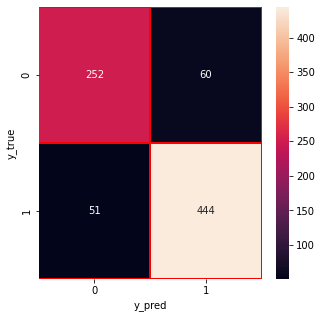

In [ ]:
#confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

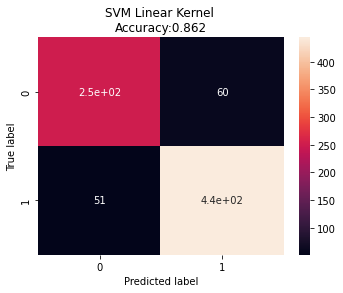

In [ ]:
# cm = confusion_matrix(y_test, preds) 

# # Transform to df for easier plotting
# cm_df = pd.DataFrame(cm,
#                      index = ['0','1'], 
#                      columns = ['0','1'])

# import seaborn as sns
# plt.figure(figsize=(5.5,4))
# sns.heatmap(cm_df, annot=True)
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, preds)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
from sklearn.metrics import classification_report
print(accuracy_score(y_test, preds))

0.8029739776951673


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
from sklearn.metrics import classification_report
print(accuracy_score(y_test, preds))

0.7472118959107806
